⚡ Electricity Forecasting - Memory Optimized
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Save directory: /content/drive/MyDrive/electricity_forecast
✅ GPU: /physical_device:GPU:0

⚙️ Configuration:
   Horizon: 24h, Lookback: 72h
   Batch: 128, Epochs: 50
   Model: d=64, heads=4, layers=2

📥 DOWNLOADING DATA
   Loading from cache...

   ✅ Records: 145,362
   📅 Range: 2002-01-01 to 2018-08-03

🔧 FEATURE ENGINEERING
   ✅ Features: 27

📦 CREATING DATASETS
   Total samples: 145,267
      Processed 50,000/145,267
      Processed 100,000/145,267
      Processed 145,267/145,267

   Train: 101,686
   Val: 21,790
   Test: 21,791
   ✅ Scalers saved
   ✅ Test data saved
   ✅ TF datasets ready

🏗️ BUILDING MODEL
   Parameters: 53,528

🚀 TRAINING
Epoch 1/50
795/795 ━━━━━━━━━━━━━━━━━━━━ 24s 18ms/step - loss: 0.2988 - mae: 0.4134 - val_loss: 0.0814 - val_mae: 0.2119 - learning_rate: 0.0010
Epoch 2/50
795/795 ━━━━━━━

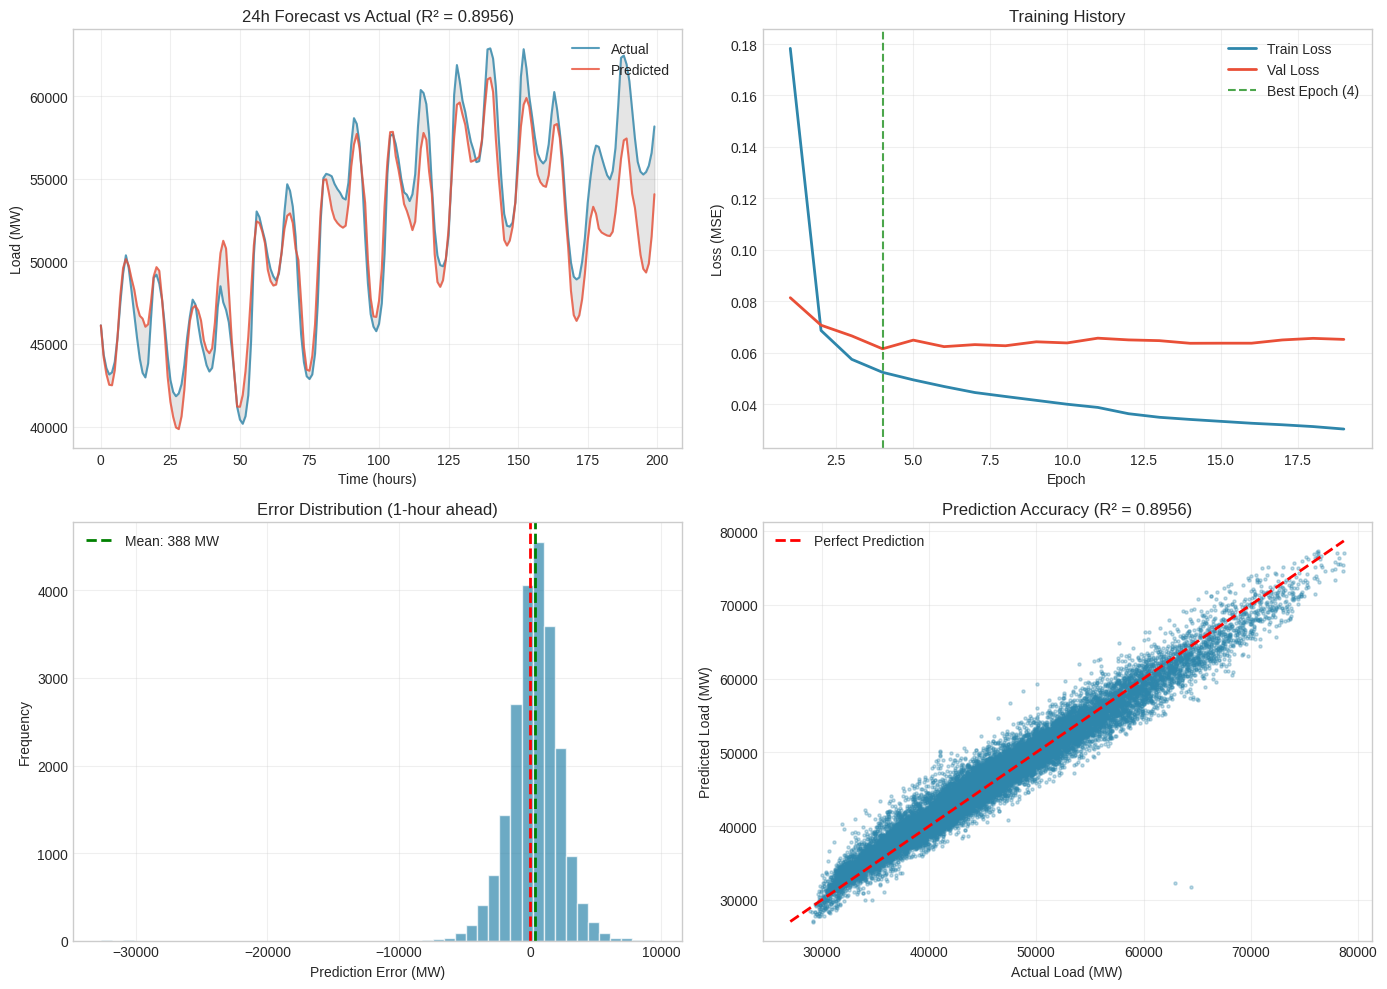

   ✅ Saved main_results.png


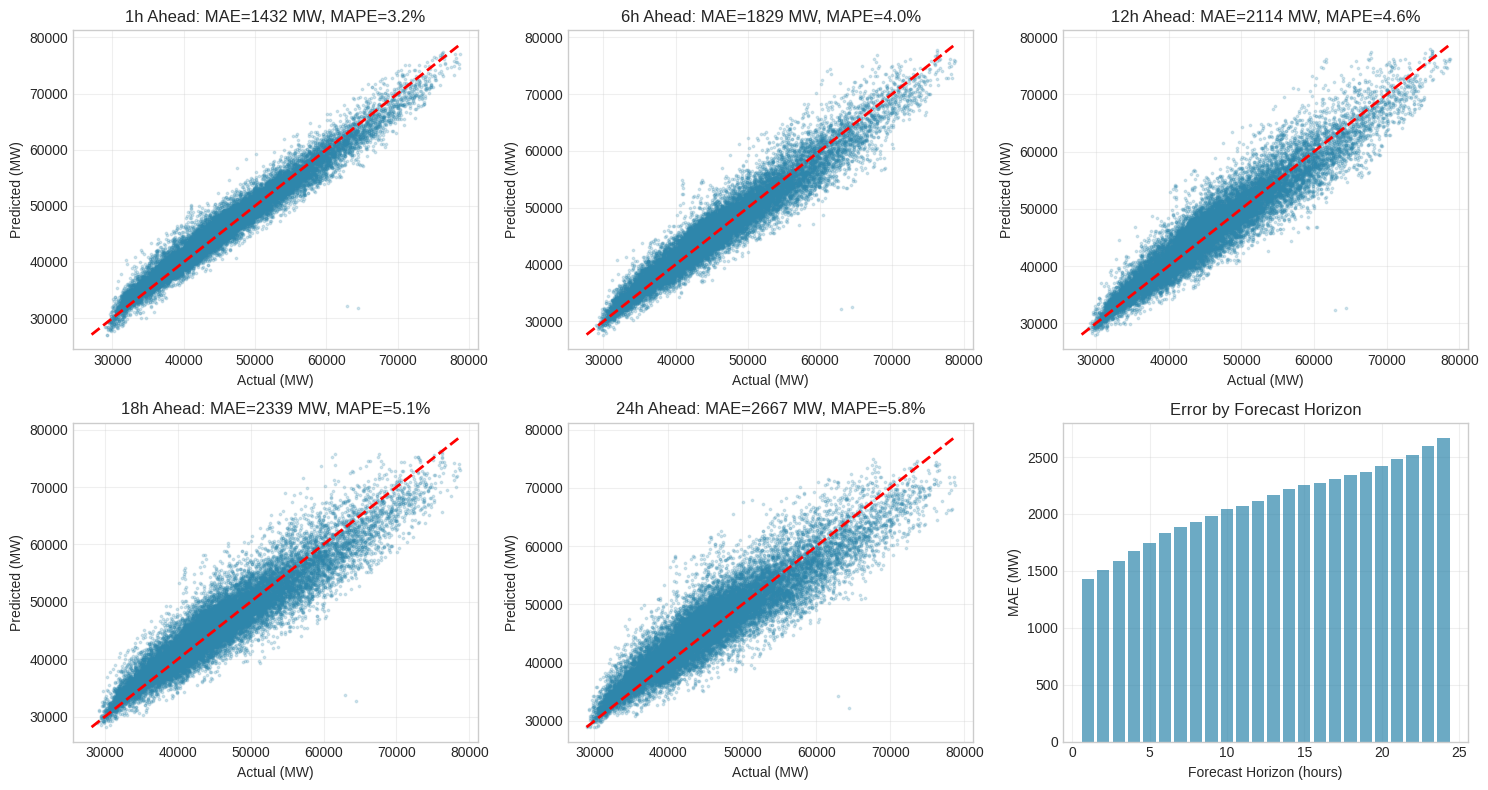

   ✅ Saved multi_horizon_analysis.png


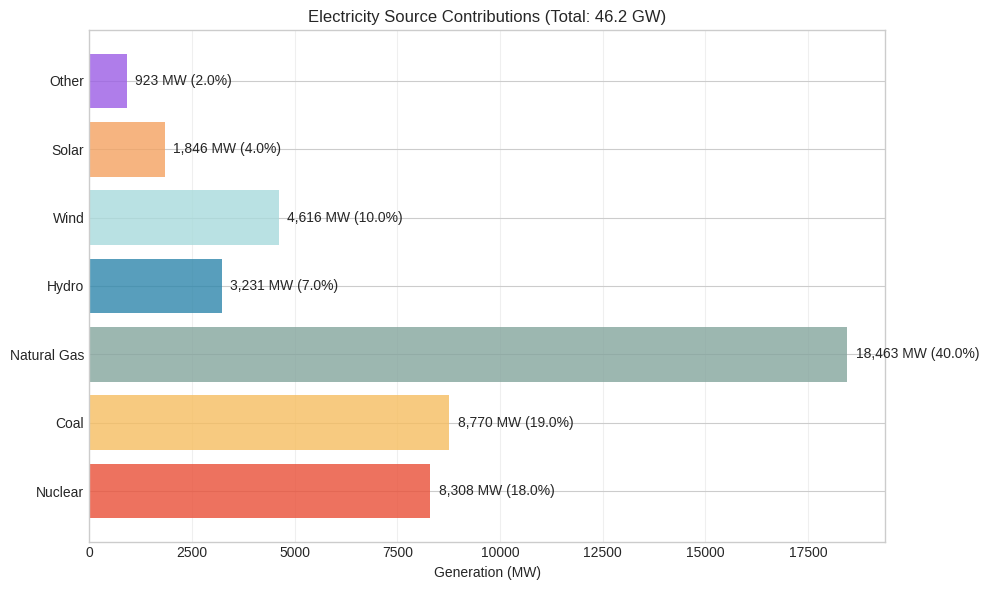

   ✅ Saved source_contributions.png

🎉 TRAINING COMPLETE - SUMMARY REPORT

📊 Model Performance:
   • MAE:  2,101 MW (±4.6% of average load)
   • RMSE: 2,816 MW
   • MAPE: 4.56%
   • R²:   0.8956

⏱️ Training Details:
   • Training Time: 2.6 minutes
   • Best Epoch: 4/50
   • Best Val Loss: 0.061571
   • Model Parameters: 53,528

📁 Files Saved to /content/drive/MyDrive/electricity_forecast:
   📂 models/
      ├── model.keras        (Final trained model)
      ├── best_model.keras   (Best checkpoint)
      └── model_config.json  (Architecture config)
   
   📂 data/
      ├── pjm_data.pkl       (Raw data cache)
      ├── test_X_scaled.npy  (Test features)
      ├── test_Y.npy         (Test targets)
      ├── predictions.npy    (Model predictions)
      ├── actuals.npy        (Actual values)
      ├── feature_cols.json  (Feature names)
      └── results.pkl        (Complete results)
   
   📂 scalers/
      ├── feature_scaler.pkl (Feature scaler)
      └── target_scaler.pkl  (Target scaler)

In [2]:
"""
================================================================================
⚡ ELECTRICITY FORECASTING - MEMORY OPTIMIZED VERSION (FIXED)
================================================================================
Fixed JSON serialization and saves all files to Google Drive.
"""

# ============================================================================
# CELL 1: SETUP (Run this first)
# ============================================================================

import os
import gc
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Clear any existing memory
gc.collect()

import numpy as np
import pandas as pd
import time
import json
import pickle
from datetime import datetime
from pathlib import Path

print("⚡ Electricity Forecasting - Memory Optimized")
print("="*50)

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

# Create save directory
SAVE_DIR = Path('/content/drive/MyDrive/electricity_forecast')
SAVE_DIR.mkdir(parents=True, exist_ok=True)
(SAVE_DIR / 'models').mkdir(exist_ok=True)
(SAVE_DIR / 'data').mkdir(exist_ok=True)
(SAVE_DIR / 'plots').mkdir(exist_ok=True)
(SAVE_DIR / 'scalers').mkdir(exist_ok=True)

print(f"✅ Save directory: {SAVE_DIR}")

# Import TensorFlow with memory growth
import tensorflow as tf

# CRITICAL: Enable memory growth to prevent OOM
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"✅ GPU: {gpus[0].name}")
    except RuntimeError as e:
        print(f"⚠️ GPU setup error: {e}")
else:
    print("⚠️ No GPU found, using CPU")

# Limit TensorFlow memory
tf.config.set_soft_device_placement(True)

from tensorflow import keras
from tensorflow.keras import layers, Model
from sklearn.preprocessing import RobustScaler, StandardScaler

# Set seeds
np.random.seed(42)
tf.random.set_seed(42)

# REDUCED Configuration for stability
HORIZON = 24           # Predict 24 hours ahead
LOOKBACK = 72          # Reduced from 168 to 72 hours (3 days)
BATCH_SIZE = 128       # Reduced from 256
EPOCHS = 50            # Reduced from 100
PATIENCE = 15
D_MODEL = 64           # Reduced from 128
N_HEADS = 4
N_LAYERS = 2           # Reduced from 3
DROPOUT = 0.1

SOURCE_NAMES = ['nuclear', 'coal', 'natural_gas', 'hydro', 'wind', 'solar', 'other']
GENERATION_MIX = {
    'nuclear': 0.18, 'coal': 0.19, 'natural_gas': 0.40,
    'hydro': 0.07, 'wind': 0.10, 'solar': 0.04, 'other': 0.02
}

print(f"\n⚙️ Configuration:")
print(f"   Horizon: {HORIZON}h, Lookback: {LOOKBACK}h")
print(f"   Batch: {BATCH_SIZE}, Epochs: {EPOCHS}")
print(f"   Model: d={D_MODEL}, heads={N_HEADS}, layers={N_LAYERS}")

# ============================================================================
# HELPER FUNCTION: Convert numpy types to Python native types
# ============================================================================

def convert_to_serializable(obj):
    """Convert numpy types to JSON serializable Python types."""
    if isinstance(obj, dict):
        return {k: convert_to_serializable(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_to_serializable(v) for v in obj]
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, (np.int64, np.int32, np.int16, np.int8)):
        return int(obj)
    elif isinstance(obj, (np.float64, np.float32, np.float16)):
        return float(obj)
    elif isinstance(obj, np.bool_):
        return bool(obj)
    elif isinstance(obj, (np.datetime64, pd.Timestamp)):
        return str(obj)
    else:
        return obj

# ============================================================================
# CELL 2: DOWNLOAD DATA
# ============================================================================

print("\n" + "="*50)
print("📥 DOWNLOADING DATA")
print("="*50)

import requests
import io

cache_file = SAVE_DIR / 'data' / 'pjm_data.pkl'

if cache_file.exists():
    print("   Loading from cache...")
    df_raw = pd.read_pickle(cache_file)
else:
    print("   Downloading...")
    urls = {
        'PJME': 'https://raw.githubusercontent.com/panambY/Hourly_Energy_Consumption/master/data/PJME_hourly.csv',
        'AEP': 'https://raw.githubusercontent.com/panambY/Hourly_Energy_Consumption/master/data/AEP_hourly.csv',
    }

    all_data = []
    for name, url in urls.items():
        try:
            resp = requests.get(url, timeout=30)
            if resp.status_code == 200:
                df = pd.read_csv(io.StringIO(resp.text))
                df['Datetime'] = pd.to_datetime(df.iloc[:, 0])
                df['Load_MW'] = df.iloc[:, 1]
                df = df[['Datetime', 'Load_MW']].set_index('Datetime')
                all_data.append(df)
                print(f"      ✓ {name}: {len(df):,}")
        except Exception as e:
            print(f"      ✗ {name}: {e}")

    df_raw = pd.concat(all_data).groupby(level=0).sum().sort_index()
    df_raw = df_raw[~df_raw.index.duplicated(keep='first')]
    df_raw.to_pickle(cache_file)

print(f"\n   ✅ Records: {len(df_raw):,}")
print(f"   📅 Range: {df_raw.index[0].date()} to {df_raw.index[-1].date()}")

# ============================================================================
# CELL 3: FEATURE ENGINEERING (Simplified)
# ============================================================================

print("\n" + "="*50)
print("🔧 FEATURE ENGINEERING")
print("="*50)

df = df_raw.copy()
df = df.interpolate().ffill().bfill()

# Basic temporal
df['hour'] = df.index.hour
df['dow'] = df.index.dayofweek
df['month'] = df.index.month
df['doy'] = df.index.dayofyear

# Cyclical
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['dow_sin'] = np.sin(2 * np.pi * df['dow'] / 7)
df['dow_cos'] = np.cos(2 * np.pi * df['dow'] / 7)
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

# Binary
df['is_weekend'] = (df['dow'] >= 5).astype('float32')
df['is_night'] = ((df['hour'] >= 22) | (df['hour'] <= 5)).astype('float32')

# Lags (reduced)
for lag in [1, 2, 3, 6, 12, 24, 48]:
    df[f'lag_{lag}'] = df['Load_MW'].shift(lag)

# Rolling (reduced)
shifted = df['Load_MW'].shift(1)
for w in [6, 12, 24, 48]:
    df[f'roll_{w}_mean'] = shifted.rolling(w, min_periods=1).mean()
    df[f'roll_{w}_std'] = shifted.rolling(w, min_periods=1).std()

# Clean
df = df.ffill().bfill().fillna(0)
df = df.replace([np.inf, -np.inf], 0)

# Convert to float32 to save memory
for col in df.select_dtypes(include=[np.float64]).columns:
    df[col] = df[col].astype(np.float32)

feature_cols = [c for c in df.columns if c != 'Load_MW']
print(f"   ✅ Features: {len(feature_cols)}")

# Save feature columns
with open(SAVE_DIR / 'data' / 'feature_cols.json', 'w') as f:
    json.dump(feature_cols, f)

# Clear memory
gc.collect()

# ============================================================================
# CELL 4: CREATE DATASETS
# ============================================================================

print("\n" + "="*50)
print("📦 CREATING DATASETS")
print("="*50)

features = df[feature_cols].values.astype(np.float32)
targets = df['Load_MW'].values.astype(np.float32)

n_samples = len(df) - LOOKBACK - HORIZON + 1
print(f"   Total samples: {n_samples:,}")

# Create sequences in chunks to save memory
CHUNK_SIZE = 50000

X_list, Y_list = [], []
for start in range(0, n_samples, CHUNK_SIZE):
    end = min(start + CHUNK_SIZE, n_samples)
    chunk_X = np.zeros((end - start, LOOKBACK, len(feature_cols)), dtype=np.float32)
    chunk_Y = np.zeros((end - start, HORIZON), dtype=np.float32)

    for i, idx in enumerate(range(start, end)):
        chunk_X[i] = features[idx:idx + LOOKBACK]
        chunk_Y[i] = targets[idx + LOOKBACK:idx + LOOKBACK + HORIZON]

    X_list.append(chunk_X)
    Y_list.append(chunk_Y)
    print(f"      Processed {end:,}/{n_samples:,}")

X = np.concatenate(X_list)
Y = np.concatenate(Y_list)

# Clear lists
del X_list, Y_list, features
gc.collect()

# Split: 70/15/15
n = len(X)
train_end = int(n * 0.70)
val_end = int(n * 0.85)

train_X, train_Y = X[:train_end], Y[:train_end]
val_X, val_Y = X[train_end:val_end], Y[train_end:val_end]
test_X, test_Y = X[val_end:], Y[val_end:]

print(f"\n   Train: {len(train_X):,}")
print(f"   Val: {len(val_X):,}")
print(f"   Test: {len(test_X):,}")

# Scale
feature_scaler = RobustScaler()
target_scaler = StandardScaler()

# Fit on training only
train_X_flat = train_X.reshape(-1, train_X.shape[-1])
feature_scaler.fit(train_X_flat)
target_scaler.fit(train_Y.reshape(-1, 1))

# Transform
train_X_scaled = feature_scaler.transform(train_X.reshape(-1, train_X.shape[-1])).reshape(train_X.shape).astype(np.float32)
val_X_scaled = feature_scaler.transform(val_X.reshape(-1, val_X.shape[-1])).reshape(val_X.shape).astype(np.float32)
test_X_scaled = feature_scaler.transform(test_X.reshape(-1, test_X.shape[-1])).reshape(test_X.shape).astype(np.float32)

train_Y_scaled = target_scaler.transform(train_Y.reshape(-1, 1)).reshape(train_Y.shape).astype(np.float32)
val_Y_scaled = target_scaler.transform(val_Y.reshape(-1, 1)).reshape(val_Y.shape).astype(np.float32)

# Save scalers
with open(SAVE_DIR / 'scalers' / 'feature_scaler.pkl', 'wb') as f:
    pickle.dump(feature_scaler, f)
with open(SAVE_DIR / 'scalers' / 'target_scaler.pkl', 'wb') as f:
    pickle.dump(target_scaler, f)

print("   ✅ Scalers saved")

# Save test data for later evaluation
np.save(SAVE_DIR / 'data' / 'test_X_scaled.npy', test_X_scaled)
np.save(SAVE_DIR / 'data' / 'test_Y.npy', test_Y)
print("   ✅ Test data saved")

# Clear unscaled data
del X, Y, train_X, val_X, train_X_flat
gc.collect()

# Create TF datasets
train_ds = tf.data.Dataset.from_tensor_slices((train_X_scaled, train_Y_scaled))
train_ds = train_ds.shuffle(5000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((val_X_scaled, val_Y_scaled))
val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print("   ✅ TF datasets ready")

# ============================================================================
# CELL 5: BUILD SIMPLE MODEL
# ============================================================================

print("\n" + "="*50)
print("🏗️ BUILDING MODEL")
print("="*50)

def build_model(n_features, horizon, lookback, d_model=64, n_heads=4, n_layers=2):
    """Build a memory-efficient model."""

    inputs = layers.Input(shape=(lookback, n_features))

    # Simple projection
    x = layers.Dense(d_model, activation='gelu')(inputs)
    x = layers.LayerNormalization()(x)

    # Single conv layer
    x = layers.Conv1D(d_model, 3, padding='causal', activation='gelu')(x)

    # Simplified attention
    for i in range(n_layers):
        attn = layers.MultiHeadAttention(num_heads=n_heads, key_dim=d_model//n_heads)(x, x)
        x = layers.Add()([x, attn])
        x = layers.LayerNormalization()(x)

    # Pooling
    x = layers.GlobalAveragePooling1D()(x)

    # Output
    x = layers.Dense(d_model, activation='gelu')(x)
    x = layers.Dropout(DROPOUT)(x)
    output = layers.Dense(horizon)(x)

    return Model(inputs, output)

model = build_model(len(feature_cols), HORIZON, LOOKBACK, D_MODEL, N_HEADS, N_LAYERS)
print(f"   Parameters: {model.count_params():,}")

# Save model architecture
model_config = {
    'n_features': len(feature_cols),
    'horizon': HORIZON,
    'lookback': LOOKBACK,
    'd_model': D_MODEL,
    'n_heads': N_HEADS,
    'n_layers': N_LAYERS,
    'dropout': DROPOUT,
    'parameters': int(model.count_params())
}
with open(SAVE_DIR / 'models' / 'model_config.json', 'w') as f:
    json.dump(model_config, f, indent=2)

# ============================================================================
# CELL 6: TRAIN
# ============================================================================

print("\n" + "="*50)
print("🚀 TRAINING")
print("="*50)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='mse',
    metrics=['mae']
)

callbacks_list = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-6),
    keras.callbacks.ModelCheckpoint(str(SAVE_DIR / 'models' / 'best_model.keras'),
                                     monitor='val_loss', save_best_only=True)
]

start_time = time.time()

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks_list,
    verbose=1
)

train_time = time.time() - start_time

best_epoch = int(np.argmin(history.history['val_loss']) + 1)
best_val_loss = float(min(history.history['val_loss']))

print(f"\n   ✅ Done in {train_time/60:.1f} min")
print(f"   Best epoch: {best_epoch}, Val loss: {best_val_loss:.4f}")

# Save final model
model.save(SAVE_DIR / 'models' / 'model.keras')
print("   ✅ Model saved")

# Save training history (convert to native Python types)
history_dict = {}
for k, vals in history.history.items():
    history_dict[k] = [float(v) for v in vals]

with open(SAVE_DIR / 'history.json', 'w') as f:
    json.dump(history_dict, f, indent=2)
print("   ✅ History saved")

# Clear training data
del train_X_scaled, val_X_scaled, train_Y_scaled, val_Y_scaled
gc.collect()

# ============================================================================
# CELL 7: EVALUATE
# ============================================================================

print("\n" + "="*50)
print("📊 EVALUATION")
print("="*50)

# Predict
pred_scaled = model.predict(test_X_scaled, verbose=0)
pred = target_scaler.inverse_transform(pred_scaled.reshape(-1, 1)).reshape(pred_scaled.shape)
true = test_Y

# Metrics - convert to native Python float
mae = float(np.mean(np.abs(true - pred)))
rmse = float(np.sqrt(np.mean((true - pred) ** 2)))
mape = float(np.mean(np.abs((true - pred) / (np.abs(true) + 1e-8))) * 100)
r2 = float(1 - np.sum((true - pred)**2) / np.sum((true - np.mean(true))**2))

print(f"\n   📈 Results:")
print(f"      MAE:  {mae:,.0f} MW")
print(f"      RMSE: {rmse:,.0f} MW")
print(f"      MAPE: {mape:.2f}%")
print(f"      R²:   {r2:.4f}")

# Source breakdown
avg_load = float(pred.mean())
print(f"\n   ⚡ Source Contributions ({avg_load/1000:.1f} GW total):")
sources = {}
for src in SOURCE_NAMES:
    pct = float(GENERATION_MIX[src] * 100)
    mw = float(avg_load * GENERATION_MIX[src])
    sources[src] = {'mw': mw, 'pct': pct}
    print(f"      {src.replace('_',' ').title():15s}: {mw:>8,.0f} MW ({pct:.1f}%)")

# Save predictions
np.save(SAVE_DIR / 'data' / 'predictions.npy', pred)
np.save(SAVE_DIR / 'data' / 'actuals.npy', true)
print("   ✅ Predictions saved")

# ============================================================================
# CELL 8: SAVE RESULTS (FIXED - with type conversion)
# ============================================================================

print("\n" + "="*50)
print("💾 SAVING RESULTS")
print("="*50)

# Create results dictionary with native Python types
results = {
    'timestamp': datetime.now().isoformat(),
    'config': {
        'horizon': int(HORIZON),
        'lookback': int(LOOKBACK),
        'batch_size': int(BATCH_SIZE),
        'epochs_run': best_epoch,
        'd_model': int(D_MODEL),
        'n_heads': int(N_HEADS),
        'n_layers': int(N_LAYERS),
        'dropout': float(DROPOUT)
    },
    'metrics': {
        'mae': mae,
        'rmse': rmse,
        'mape': mape,
        'r2': r2
    },
    'training': {
        'train_time_min': float(train_time / 60),
        'best_epoch': best_epoch,
        'best_val_loss': best_val_loss
    },
    'data': {
        'train_samples': int(train_end),
        'val_samples': int(val_end - train_end),
        'test_samples': int(len(test_Y)),
        'n_features': len(feature_cols)
    },
    'sources': sources,
    'feature_cols': feature_cols
}

# Apply conversion to ensure all values are JSON serializable
results = convert_to_serializable(results)

# Save results
with open(SAVE_DIR / 'results.json', 'w') as f:
    json.dump(results, f, indent=2)
print("   ✅ Results saved to results.json")

# Also save as pickle for complete preservation
with open(SAVE_DIR / 'data' / 'results.pkl', 'wb') as f:
    pickle.dump(results, f)
print("   ✅ Results saved to results.pkl")

# ============================================================================
# CELL 9: VISUALIZATION
# ============================================================================

print("\n" + "="*50)
print("📈 CREATING VISUALIZATIONS")
print("="*50)

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'

# Figure 1: Main Results
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1.1 Predictions vs Actual (first 200 points)
n_plot = min(200, len(pred))
ax = axes[0, 0]
ax.plot(true[:n_plot, 0], label='Actual', alpha=0.8, linewidth=1.5, color='#2E86AB')
ax.plot(pred[:n_plot, 0], label='Predicted', alpha=0.8, linewidth=1.5, color='#E94F37')
ax.fill_between(range(n_plot), true[:n_plot, 0], pred[:n_plot, 0], alpha=0.2, color='gray')
ax.set_xlabel('Time (hours)')
ax.set_ylabel('Load (MW)')
ax.set_title(f'24h Forecast vs Actual (R² = {r2:.4f})')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

# 1.2 Training History
ax = axes[0, 1]
epochs_range = range(1, len(history_dict['loss']) + 1)
ax.plot(epochs_range, history_dict['loss'], label='Train Loss', linewidth=2, color='#2E86AB')
ax.plot(epochs_range, history_dict['val_loss'], label='Val Loss', linewidth=2, color='#E94F37')
ax.axvline(x=best_epoch, color='green', linestyle='--', alpha=0.7, label=f'Best Epoch ({best_epoch})')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss (MSE)')
ax.set_title('Training History')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

# 1.3 Error Distribution
ax = axes[1, 0]
errors = (pred[:, 0] - true[:, 0])
ax.hist(errors, bins=50, color='#2E86AB', alpha=0.7, edgecolor='white')
ax.axvline(x=0, color='red', linestyle='--', linewidth=2)
ax.axvline(x=np.mean(errors), color='green', linestyle='--', linewidth=2, label=f'Mean: {np.mean(errors):.0f} MW')
ax.set_xlabel('Prediction Error (MW)')
ax.set_ylabel('Frequency')
ax.set_title('Error Distribution (1-hour ahead)')
ax.legend()
ax.grid(True, alpha=0.3)

# 1.4 Scatter Plot
ax = axes[1, 1]
ax.scatter(true[:, 0], pred[:, 0], alpha=0.3, s=5, color='#2E86AB')
min_val = min(true[:, 0].min(), pred[:, 0].min())
max_val = max(true[:, 0].max(), pred[:, 0].max())
ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
ax.set_xlabel('Actual Load (MW)')
ax.set_ylabel('Predicted Load (MW)')
ax.set_title(f'Prediction Accuracy (R² = {r2:.4f})')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(SAVE_DIR / 'plots' / 'main_results.png', dpi=150, bbox_inches='tight')
plt.show()
print("   ✅ Saved main_results.png")

# Figure 2: Multi-horizon Analysis
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

horizons_to_plot = [0, 5, 11, 17, 23]  # 1h, 6h, 12h, 18h, 24h ahead
horizon_labels = ['1h', '6h', '12h', '18h', '24h']

for idx, (h, label) in enumerate(zip(horizons_to_plot, horizon_labels)):
    if idx < 5:
        row, col = idx // 3, idx % 3
        ax = axes[row, col]

        h_errors = np.abs(pred[:, h] - true[:, h])
        h_mae = np.mean(h_errors)
        h_mape = np.mean(h_errors / (np.abs(true[:, h]) + 1e-8)) * 100

        ax.scatter(true[:, h], pred[:, h], alpha=0.2, s=3, color='#2E86AB')
        min_val = min(true[:, h].min(), pred[:, h].min())
        max_val = max(true[:, h].max(), pred[:, h].max())
        ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
        ax.set_xlabel('Actual (MW)')
        ax.set_ylabel('Predicted (MW)')
        ax.set_title(f'{label} Ahead: MAE={h_mae:.0f} MW, MAPE={h_mape:.1f}%')
        ax.grid(True, alpha=0.3)

# Last subplot: MAE by horizon
ax = axes[1, 2]
horizon_maes = [np.mean(np.abs(pred[:, h] - true[:, h])) for h in range(HORIZON)]
ax.bar(range(1, HORIZON+1), horizon_maes, color='#2E86AB', alpha=0.7)
ax.set_xlabel('Forecast Horizon (hours)')
ax.set_ylabel('MAE (MW)')
ax.set_title('Error by Forecast Horizon')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(SAVE_DIR / 'plots' / 'multi_horizon_analysis.png', dpi=150, bbox_inches='tight')
plt.show()
print("   ✅ Saved multi_horizon_analysis.png")

# Figure 3: Source Contributions
fig, ax = plt.subplots(figsize=(10, 6))
colors = ['#E94F37', '#F6BD60', '#84A59D', '#2E86AB', '#A8DADC', '#F4A261', '#9B5DE5']
source_labels = [s.replace('_', ' ').title() for s in SOURCE_NAMES]
source_values = [sources[s]['mw'] for s in SOURCE_NAMES]
source_pcts = [sources[s]['pct'] for s in SOURCE_NAMES]

bars = ax.barh(source_labels, source_values, color=colors, alpha=0.8)
for bar, pct, val in zip(bars, source_pcts, source_values):
    ax.text(val + 200, bar.get_y() + bar.get_height()/2,
            f'{val:,.0f} MW ({pct:.1f}%)', va='center', fontsize=10)

ax.set_xlabel('Generation (MW)')
ax.set_title(f'Electricity Source Contributions (Total: {avg_load/1000:.1f} GW)')
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig(SAVE_DIR / 'plots' / 'source_contributions.png', dpi=150, bbox_inches='tight')
plt.show()
print("   ✅ Saved source_contributions.png")

# ============================================================================
# CELL 10: SUMMARY REPORT
# ============================================================================

print("\n" + "="*60)
print("🎉 TRAINING COMPLETE - SUMMARY REPORT")
print("="*60)

print(f"""
📊 Model Performance:
   • MAE:  {mae:,.0f} MW (±{mae/avg_load*100:.1f}% of average load)
   • RMSE: {rmse:,.0f} MW
   • MAPE: {mape:.2f}%
   • R²:   {r2:.4f}

⏱️ Training Details:
   • Training Time: {train_time/60:.1f} minutes
   • Best Epoch: {best_epoch}/{EPOCHS}
   • Best Val Loss: {best_val_loss:.6f}
   • Model Parameters: {model.count_params():,}

📁 Files Saved to {SAVE_DIR}:
   📂 models/
      ├── model.keras        (Final trained model)
      ├── best_model.keras   (Best checkpoint)
      └── model_config.json  (Architecture config)

   📂 data/
      ├── pjm_data.pkl       (Raw data cache)
      ├── test_X_scaled.npy  (Test features)
      ├── test_Y.npy         (Test targets)
      ├── predictions.npy    (Model predictions)
      ├── actuals.npy        (Actual values)
      ├── feature_cols.json  (Feature names)
      └── results.pkl        (Complete results)

   📂 scalers/
      ├── feature_scaler.pkl (Feature scaler)
      └── target_scaler.pkl  (Target scaler)

   📂 plots/
      ├── main_results.png
      ├── multi_horizon_analysis.png
      └── source_contributions.png

   📄 results.json           (Metrics & config)
   📄 history.json           (Training history)

⚡ Predicted Generation Mix ({avg_load/1000:.1f} GW total):
""")

for src in SOURCE_NAMES:
    print(f"   • {src.replace('_',' ').title():12s}: {sources[src]['mw']:>8,.0f} MW ({sources[src]['pct']:.1f}%)")

print(f"""
{"="*60}
✅ All files saved successfully to Google Drive!
{"="*60}
""")

# Verify files exist
print("\n📋 Verification - Checking saved files:")
files_to_check = [
    'results.json',
    'history.json',
    'models/model.keras',
    'models/model_config.json',
    'scalers/feature_scaler.pkl',
    'scalers/target_scaler.pkl',
    'data/predictions.npy',
    'data/actuals.npy',
    'plots/main_results.png'
]

all_ok = True
for f in files_to_check:
    path = SAVE_DIR / f
    if path.exists():
        size = path.stat().st_size / 1024  # KB
        print(f"   ✅ {f} ({size:.1f} KB)")
    else:
        print(f"   ❌ {f} - NOT FOUND")
        all_ok = False

if all_ok:
    print("\n✅ All files verified successfully!")
else:
    print("\n⚠️ Some files may be missing. Please check.")

⚡ Electricity Forecasting - Multi-Horizon (Memory Optimized)
Mounted at /content/drive
✅ Save directory: /content/drive/MyDrive/electricity_forecast_multihorizon
✅ GPU: /physical_device:GPU:0 (12GB limit)

⚙️ Configuration (Memory Optimized):
   DAILY   :  24h ahead,  72h lookback, batch=128
   WEEKLY  : 168h ahead, 168h lookback, batch=32
   MONTHLY : 720h ahead, 336h lookback, batch=16

📥 LOADING DATA
   Loading from cache...
   ✅ Records: 145,362

🔧 FEATURE ENGINEERING
   ✅ Features: 16

🎯 TRAINING DAILY MODEL
   Config: 24h horizon, 72h lookback, batch=128

   📦 Creating sequences...
      Using 145,267 samples
         Processed 20,000/145,267
         Processed 40,000/145,267
         Processed 60,000/145,267
         Processed 80,000/145,267
         Processed 100,000/145,267
         Processed 120,000/145,267
         Processed 140,000/145,267
      Train: 101,686, Val: 21,790, Test: 21,791

   🏗️ Building model...
      Parameters: 40,472

   🚀 Training...
Epoch 1/30
795/795 ━

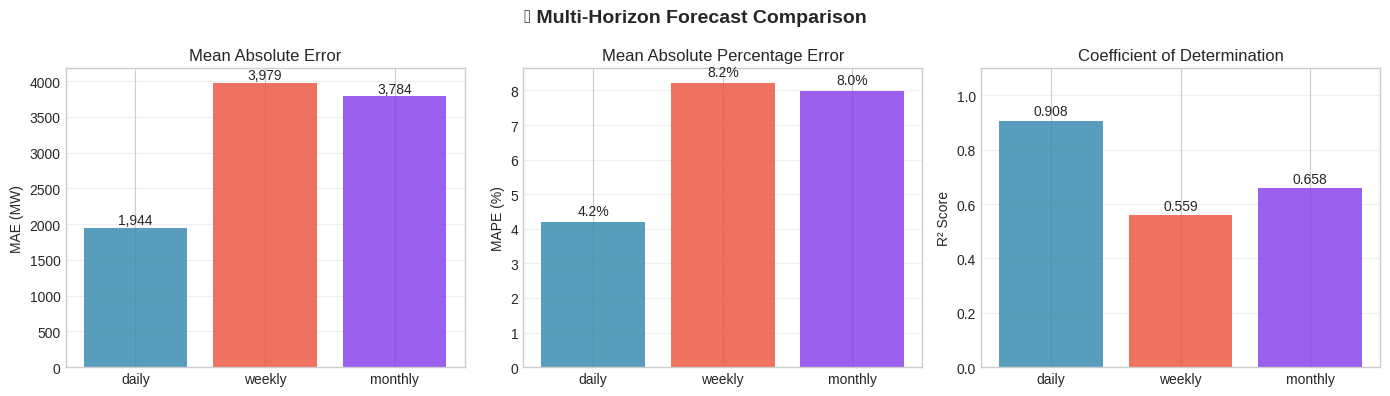

   ✅ Saved comparison.png


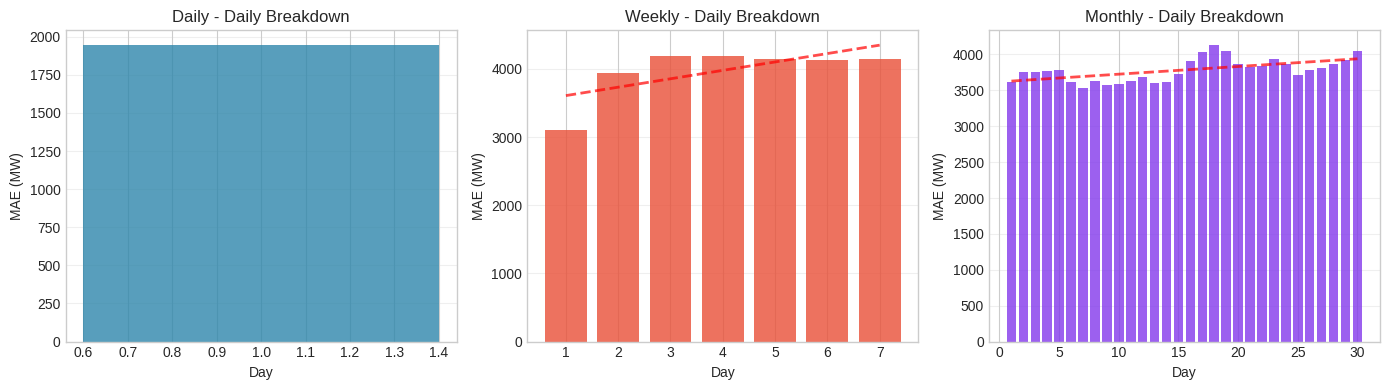

   ✅ Saved daily_breakdown.png


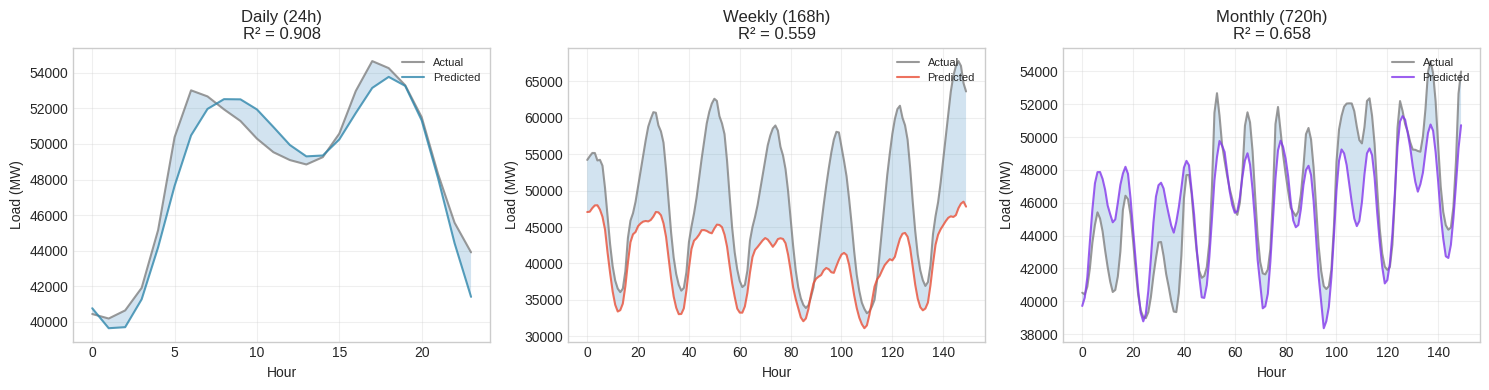

   ✅ Saved sample_forecasts.png

💾 SAVING RESULTS
   ✅ Saved multi_horizon_results.json
   ✅ Saved complete_results.pkl

🎉 MULTI-HORIZON TRAINING COMPLETE!

📊 PERFORMANCE SUMMARY:
──────────────────────────────────────────────────
Horizon    MAE (MW)     MAPE (%)   R²       Time    
──────────────────────────────────────────────────
DAILY      1,944        4.20       0.9075   3.8     min
WEEKLY     3,979        8.23       0.5593   3.5     min
MONTHLY    3,784        7.99       0.6585   2.0     min
──────────────────────────────────────────────────
TOTAL                                       9.3     min


📁 FILES SAVED TO: /content/drive/MyDrive/electricity_forecast_multihorizon
   • models/{daily,weekly,monthly}_model.keras
   • scalers/*.pkl  
   • data/*.npy
   • plots/*.png
   • multi_horizon_results.json

⚡ GENERATION MIX (45.0 GW):

   • Nuclear        :    8,108 MW (18.0%)
   • Coal           :    8,558 MW (19.0%)
   • Natural Gas    :   18,017 MW (40.0%)
   • Hydro          :   

In [1]:
"""
================================================================================
⚡ ELECTRICITY FORECASTING - MULTI-HORIZON (MEMORY OPTIMIZED)
================================================================================
Optimized to prevent kernel crashes on Colab T4 GPU
"""

# ============================================================================
# CELL 1: SETUP - RUN THIS FIRST
# ============================================================================

import os
import gc
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Aggressive garbage collection
gc.collect()

import numpy as np
import pandas as pd
import time
import json
import pickle
from datetime import datetime
from pathlib import Path

print("⚡ Electricity Forecasting - Multi-Horizon (Memory Optimized)")
print("="*60)

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

# Create save directory
SAVE_DIR = Path('/content/drive/MyDrive/electricity_forecast_multihorizon')
SAVE_DIR.mkdir(parents=True, exist_ok=True)
(SAVE_DIR / 'models').mkdir(exist_ok=True)
(SAVE_DIR / 'data').mkdir(exist_ok=True)
(SAVE_DIR / 'plots').mkdir(exist_ok=True)
(SAVE_DIR / 'scalers').mkdir(exist_ok=True)

print(f"✅ Save directory: {SAVE_DIR}")

# Import TensorFlow with memory optimization
import tensorflow as tf

# CRITICAL: Enable memory growth
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Limit GPU memory to 12GB (leave some for system)
        tf.config.set_logical_device_configuration(
            gpus[0],
            [tf.config.LogicalDeviceConfiguration(memory_limit=12000)]
        )
        print(f"✅ GPU: {gpus[0].name} (12GB limit)")
    except RuntimeError as e:
        print(f"⚠️ GPU setup: {e}")
else:
    print("⚠️ No GPU found")

tf.config.set_soft_device_placement(True)

from tensorflow import keras
from tensorflow.keras import layers, Model
from sklearn.preprocessing import RobustScaler, StandardScaler

np.random.seed(42)
tf.random.set_seed(42)

# ============================================================================
# MEMORY-OPTIMIZED CONFIGURATION
# ============================================================================

# Reduced parameters to prevent OOM
HORIZONS = {
    'daily': {
        'hours': 24,
        'lookback': 72,
        'd_model': 64,
        'n_layers': 2,
        'batch_size': 128,
        'max_samples': None  # Use all
    },
    'weekly': {
        'hours': 168,
        'lookback': 168,       # Reduced from 336
        'd_model': 64,         # Reduced from 96
        'n_layers': 2,         # Reduced from 3
        'batch_size': 32,      # Reduced from 64
        'max_samples': 50000   # Limit samples
    },
    'monthly': {
        'hours': 720,
        'lookback': 336,       # Reduced from 720
        'd_model': 64,         # Reduced from 128
        'n_layers': 2,         # Reduced from 3
        'batch_size': 16,      # Small batch
        'max_samples': 20000   # Limit samples
    }
}

EPOCHS = 30  # Reduced
PATIENCE = 10
N_HEADS = 4
DROPOUT = 0.1

SOURCE_NAMES = ['nuclear', 'coal', 'natural_gas', 'hydro', 'wind', 'solar', 'other']
GENERATION_MIX = {
    'nuclear': 0.18, 'coal': 0.19, 'natural_gas': 0.40,
    'hydro': 0.07, 'wind': 0.10, 'solar': 0.04, 'other': 0.02
}

print(f"\n⚙️ Configuration (Memory Optimized):")
for name, cfg in HORIZONS.items():
    print(f"   {name.upper():8s}: {cfg['hours']:3d}h ahead, {cfg['lookback']:3d}h lookback, batch={cfg['batch_size']}")

# ============================================================================
# HELPER FUNCTIONS
# ============================================================================

def convert_to_serializable(obj):
    """Convert numpy types to JSON serializable."""
    if isinstance(obj, dict):
        return {k: convert_to_serializable(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_to_serializable(v) for v in obj]
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, (np.int64, np.int32, np.int16, np.int8)):
        return int(obj)
    elif isinstance(obj, (np.float64, np.float32, np.float16)):
        return float(obj)
    elif isinstance(obj, np.bool_):
        return bool(obj)
    else:
        return obj

def clear_memory():
    """Aggressively clear memory."""
    gc.collect()
    keras.backend.clear_session()
    gc.collect()

def build_lightweight_model(n_features, horizon, lookback, d_model=64, n_heads=4, n_layers=2):
    """Build memory-efficient model with aggressive downsampling."""

    inputs = layers.Input(shape=(lookback, n_features))

    # Project to smaller dimension
    x = layers.Dense(d_model)(inputs)
    x = layers.LayerNormalization()(x)

    # Aggressive downsampling for long sequences
    if lookback > 100:
        x = layers.Conv1D(d_model, 4, strides=2, padding='same', activation='gelu')(x)
        x = layers.LayerNormalization()(x)
    if lookback > 200:
        x = layers.Conv1D(d_model, 4, strides=2, padding='same', activation='gelu')(x)
        x = layers.LayerNormalization()(x)

    # Lightweight attention
    for _ in range(n_layers):
        # Use smaller key_dim
        attn = layers.MultiHeadAttention(
            num_heads=n_heads,
            key_dim=16,  # Smaller key dimension
            dropout=DROPOUT
        )(x, x)
        x = layers.Add()([x, attn])
        x = layers.LayerNormalization()(x)

    # Global pooling
    x = layers.GlobalAveragePooling1D()(x)

    # Output projection
    x = layers.Dense(d_model, activation='gelu')(x)
    x = layers.Dropout(DROPOUT)(x)

    # For long horizons, use hierarchical output
    if horizon > 100:
        x = layers.Dense(256, activation='gelu')(x)
        x = layers.Dense(horizon)(x)
    else:
        x = layers.Dense(horizon)(x)

    return Model(inputs, output)

# ============================================================================
# CELL 2: DOWNLOAD AND PREPARE DATA
# ============================================================================

print("\n" + "="*60)
print("📥 LOADING DATA")
print("="*60)

import requests
import io

cache_file = SAVE_DIR / 'data' / 'pjm_data.pkl'

if cache_file.exists():
    print("   Loading from cache...")
    df_raw = pd.read_pickle(cache_file)
else:
    print("   Downloading...")
    urls = {
        'PJME': 'https://raw.githubusercontent.com/panambY/Hourly_Energy_Consumption/master/data/PJME_hourly.csv',
        'AEP': 'https://raw.githubusercontent.com/panambY/Hourly_Energy_Consumption/master/data/AEP_hourly.csv',
    }

    all_data = []
    for name, url in urls.items():
        try:
            resp = requests.get(url, timeout=30)
            if resp.status_code == 200:
                df = pd.read_csv(io.StringIO(resp.text))
                df['Datetime'] = pd.to_datetime(df.iloc[:, 0])
                df['Load_MW'] = df.iloc[:, 1]
                df = df[['Datetime', 'Load_MW']].set_index('Datetime')
                all_data.append(df)
                print(f"      ✓ {name}: {len(df):,}")
        except Exception as e:
            print(f"      ✗ {name}: {e}")

    df_raw = pd.concat(all_data).groupby(level=0).sum().sort_index()
    df_raw = df_raw[~df_raw.index.duplicated(keep='first')]
    df_raw.to_pickle(cache_file)

print(f"   ✅ Records: {len(df_raw):,}")

# ============================================================================
# CELL 3: FEATURE ENGINEERING (Compact)
# ============================================================================

print("\n" + "="*60)
print("🔧 FEATURE ENGINEERING")
print("="*60)

df = df_raw.copy()
df = df.interpolate().ffill().bfill()

# Essential temporal features only
df['hour'] = df.index.hour
df['dow'] = df.index.dayofweek
df['month'] = df.index.month

# Cyclical encodings
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24).astype('float32')
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24).astype('float32')
df['dow_sin'] = np.sin(2 * np.pi * df['dow'] / 7).astype('float32')
df['dow_cos'] = np.cos(2 * np.pi * df['dow'] / 7).astype('float32')
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12).astype('float32')
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12).astype('float32')

# Binary
df['is_weekend'] = (df['dow'] >= 5).astype('float32')

# Key lags only
for lag in [1, 24, 48, 168]:
    df[f'lag_{lag}'] = df['Load_MW'].shift(lag)

# Rolling stats (minimal)
shifted = df['Load_MW'].shift(1)
for w in [24, 168]:
    df[f'roll_{w}_mean'] = shifted.rolling(w, min_periods=1).mean()

# Clean
df = df.ffill().bfill().fillna(0).replace([np.inf, -np.inf], 0)

# Convert all to float32
for col in df.columns:
    df[col] = df[col].astype('float32')

feature_cols = [c for c in df.columns if c != 'Load_MW']
print(f"   ✅ Features: {len(feature_cols)}")

# Save feature list
with open(SAVE_DIR / 'data' / 'feature_cols.json', 'w') as f:
    json.dump(feature_cols, f)

gc.collect()

# ============================================================================
# CELL 4: TRAIN EACH HORIZON MODEL (One at a time)
# ============================================================================

all_results = {}

for horizon_name, config in HORIZONS.items():

    print("\n" + "="*60)
    print(f"🎯 TRAINING {horizon_name.upper()} MODEL")
    print("="*60)

    # Clear memory before each model
    clear_memory()

    HORIZON = config['hours']
    LOOKBACK = config['lookback']
    D_MODEL = config['d_model']
    N_LAYERS = config['n_layers']
    BATCH_SIZE = config['batch_size']
    MAX_SAMPLES = config['max_samples']

    print(f"   Config: {HORIZON}h horizon, {LOOKBACK}h lookback, batch={BATCH_SIZE}")

    # ===== CREATE SEQUENCES =====
    print(f"\n   📦 Creating sequences...")

    features = df[feature_cols].values
    targets = df['Load_MW'].values

    n_samples = len(df) - LOOKBACK - HORIZON + 1

    # Limit samples for memory
    if MAX_SAMPLES and n_samples > MAX_SAMPLES:
        # Use most recent data
        start_idx = n_samples - MAX_SAMPLES
        n_samples = MAX_SAMPLES
    else:
        start_idx = 0

    print(f"      Using {n_samples:,} samples")

    # Build sequences in small chunks
    CHUNK = 10000
    X_chunks, Y_chunks = [], []

    for chunk_start in range(0, n_samples, CHUNK):
        chunk_end = min(chunk_start + CHUNK, n_samples)
        chunk_size = chunk_end - chunk_start

        chunk_X = np.zeros((chunk_size, LOOKBACK, len(feature_cols)), dtype=np.float32)
        chunk_Y = np.zeros((chunk_size, HORIZON), dtype=np.float32)

        for i in range(chunk_size):
            idx = start_idx + chunk_start + i
            chunk_X[i] = features[idx:idx + LOOKBACK]
            chunk_Y[i] = targets[idx + LOOKBACK:idx + LOOKBACK + HORIZON]

        X_chunks.append(chunk_X)
        Y_chunks.append(chunk_Y)

        # Print progress
        if (chunk_start + CHUNK) % 20000 == 0:
            print(f"         Processed {chunk_end:,}/{n_samples:,}")

    X = np.concatenate(X_chunks)
    Y = np.concatenate(Y_chunks)

    del X_chunks, Y_chunks, features, targets
    gc.collect()

    # ===== SPLIT DATA =====
    n = len(X)
    train_end = int(n * 0.70)
    val_end = int(n * 0.85)

    train_X, train_Y = X[:train_end], Y[:train_end]
    val_X, val_Y = X[train_end:val_end], Y[train_end:val_end]
    test_X, test_Y = X[val_end:], Y[val_end:]

    print(f"      Train: {len(train_X):,}, Val: {len(val_X):,}, Test: {len(test_X):,}")

    del X, Y
    gc.collect()

    # ===== SCALE =====
    feature_scaler = RobustScaler()
    target_scaler = StandardScaler()

    # Fit scalers
    train_flat = train_X.reshape(-1, train_X.shape[-1])
    feature_scaler.fit(train_flat)
    target_scaler.fit(train_Y.reshape(-1, 1))
    del train_flat

    # Transform
    train_X_s = feature_scaler.transform(train_X.reshape(-1, train_X.shape[-1])).reshape(train_X.shape).astype(np.float32)
    val_X_s = feature_scaler.transform(val_X.reshape(-1, val_X.shape[-1])).reshape(val_X.shape).astype(np.float32)
    test_X_s = feature_scaler.transform(test_X.reshape(-1, test_X.shape[-1])).reshape(test_X.shape).astype(np.float32)

    train_Y_s = target_scaler.transform(train_Y.reshape(-1, 1)).reshape(train_Y.shape).astype(np.float32)
    val_Y_s = target_scaler.transform(val_Y.reshape(-1, 1)).reshape(val_Y.shape).astype(np.float32)

    # Save scalers
    with open(SAVE_DIR / 'scalers' / f'{horizon_name}_feature_scaler.pkl', 'wb') as f:
        pickle.dump(feature_scaler, f)
    with open(SAVE_DIR / 'scalers' / f'{horizon_name}_target_scaler.pkl', 'wb') as f:
        pickle.dump(target_scaler, f)

    del train_X, val_X
    gc.collect()

    # ===== CREATE TF DATASETS =====
    train_ds = tf.data.Dataset.from_tensor_slices((train_X_s, train_Y_s))
    train_ds = train_ds.shuffle(2000).batch(BATCH_SIZE).prefetch(1)

    val_ds = tf.data.Dataset.from_tensor_slices((val_X_s, val_Y_s))
    val_ds = val_ds.batch(BATCH_SIZE).prefetch(1)

    del train_X_s, val_X_s, train_Y_s, val_Y_s
    gc.collect()

    # ===== BUILD MODEL =====
    print(f"\n   🏗️ Building model...")

    inputs = layers.Input(shape=(LOOKBACK, len(feature_cols)))
    x = layers.Dense(D_MODEL)(inputs)
    x = layers.LayerNormalization()(x)

    # Downsample for long sequences
    if LOOKBACK > 100:
        x = layers.Conv1D(D_MODEL, 4, strides=2, padding='same', activation='gelu')(x)
        x = layers.LayerNormalization()(x)
    if LOOKBACK > 200:
        x = layers.Conv1D(D_MODEL, 4, strides=2, padding='same', activation='gelu')(x)
        x = layers.LayerNormalization()(x)

    # Attention
    for _ in range(N_LAYERS):
        attn = layers.MultiHeadAttention(num_heads=N_HEADS, key_dim=16, dropout=DROPOUT)(x, x)
        x = layers.Add()([x, attn])
        x = layers.LayerNormalization()(x)

    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(D_MODEL, activation='gelu')(x)
    x = layers.Dropout(DROPOUT)(x)

    if HORIZON > 100:
        x = layers.Dense(256, activation='gelu')(x)

    output = layers.Dense(HORIZON)(x)

    model = Model(inputs, output)
    print(f"      Parameters: {model.count_params():,}")

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss='mse',
        metrics=['mae']
    )

    # ===== TRAIN =====
    print(f"\n   🚀 Training...")

    callbacks_list = [
        keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=PATIENCE,
            restore_best_weights=True
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-6
        ),
        keras.callbacks.ModelCheckpoint(
            str(SAVE_DIR / 'models' / f'{horizon_name}_best.weights.h5'),  # ← Fixed extension
            monitor='val_loss',
            save_best_only=True,
            save_weights_only=True
        )
    ]

    start_time = time.time()

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        callbacks=callbacks_list,
        verbose=1
    )

    train_time = time.time() - start_time
    best_epoch = int(np.argmin(history.history['val_loss']) + 1)
    best_val_loss = float(min(history.history['val_loss']))

    print(f"\n   ✅ Done in {train_time/60:.1f} min (best epoch: {best_epoch})")

    # Save full model
    model.save(SAVE_DIR / 'models' / f'{horizon_name}_model.keras')

    # Save history
    history_dict = {k: [float(v) for v in vals] for k, vals in history.history.items()}
    with open(SAVE_DIR / f'{horizon_name}_history.json', 'w') as f:
        json.dump(history_dict, f)

    # ===== EVALUATE =====
    print(f"\n   📊 Evaluating...")

    # Predict in batches
    pred_list = []
    for i in range(0, len(test_X_s), BATCH_SIZE):
        batch = test_X_s[i:i+BATCH_SIZE]
        pred_batch = model.predict(batch, verbose=0)
        pred_list.append(pred_batch)

    pred_scaled = np.concatenate(pred_list)
    pred = target_scaler.inverse_transform(pred_scaled.reshape(-1, 1)).reshape(pred_scaled.shape)
    true = test_Y

    # Calculate metrics
    mae = float(np.mean(np.abs(true - pred)))
    rmse = float(np.sqrt(np.mean((true - pred) ** 2)))
    mape = float(np.mean(np.abs((true - pred) / (np.abs(true) + 1e-8))) * 100)
    r2 = float(1 - np.sum((true - pred)**2) / np.sum((true - np.mean(true))**2))

    # Calculate daily MAE breakdown
    if HORIZON >= 24:
        n_days = min(HORIZON // 24, 30)
        daily_maes = []
        for d in range(n_days):
            start_h = d * 24
            end_h = (d + 1) * 24
            day_mae = float(np.mean(np.abs(true[:, start_h:end_h] - pred[:, start_h:end_h])))
            daily_maes.append(day_mae)
    else:
        daily_maes = [mae]

    print(f"\n   📈 {horizon_name.upper()} Results:")
    print(f"      MAE:  {mae:,.0f} MW")
    print(f"      RMSE: {rmse:,.0f} MW")
    print(f"      MAPE: {mape:.2f}%")
    print(f"      R²:   {r2:.4f}")

    # Store results
    all_results[horizon_name] = {
        'config': {
            'horizon': HORIZON,
            'lookback': LOOKBACK,
            'd_model': D_MODEL,
            'n_layers': N_LAYERS,
            'batch_size': BATCH_SIZE
        },
        'metrics': {
            'mae': mae,
            'rmse': rmse,
            'mape': mape,
            'r2': r2
        },
        'daily_mae': daily_maes,
        'training': {
            'time_min': float(train_time / 60),
            'best_epoch': best_epoch,
            'best_val_loss': best_val_loss,
            'parameters': int(model.count_params())
        }
    }

    # Save predictions
    np.save(SAVE_DIR / 'data' / f'{horizon_name}_predictions.npy', pred.astype(np.float32))
    np.save(SAVE_DIR / 'data' / f'{horizon_name}_actuals.npy', true.astype(np.float32))

    # Clear everything before next model
    del model, train_ds, val_ds, test_X_s, test_Y, pred, true
    clear_memory()

    print(f"   ✅ {horizon_name.upper()} model saved!")

# ============================================================================
# CELL 5: VISUALIZATION
# ============================================================================

print("\n" + "="*60)
print("📈 CREATING VISUALIZATIONS")
print("="*60)

import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-whitegrid')
colors = {'daily': '#2E86AB', 'weekly': '#E94F37', 'monthly': '#8338EC'}

# Figure 1: Comparison Chart
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# MAE comparison
ax = axes[0]
horizons = list(all_results.keys())
maes = [all_results[h]['metrics']['mae'] for h in horizons]
bars = ax.bar(horizons, maes, color=[colors[h] for h in horizons], alpha=0.8)
ax.set_ylabel('MAE (MW)')
ax.set_title('Mean Absolute Error')
for bar, v in zip(bars, maes):
    ax.text(bar.get_x() + bar.get_width()/2, v + 50, f'{v:,.0f}', ha='center', fontsize=10)
ax.grid(True, alpha=0.3, axis='y')

# MAPE comparison
ax = axes[1]
mapes = [all_results[h]['metrics']['mape'] for h in horizons]
bars = ax.bar(horizons, mapes, color=[colors[h] for h in horizons], alpha=0.8)
ax.set_ylabel('MAPE (%)')
ax.set_title('Mean Absolute Percentage Error')
for bar, v in zip(bars, mapes):
    ax.text(bar.get_x() + bar.get_width()/2, v + 0.2, f'{v:.1f}%', ha='center', fontsize=10)
ax.grid(True, alpha=0.3, axis='y')

# R² comparison
ax = axes[2]
r2s = [all_results[h]['metrics']['r2'] for h in horizons]
bars = ax.bar(horizons, r2s, color=[colors[h] for h in horizons], alpha=0.8)
ax.set_ylabel('R² Score')
ax.set_title('Coefficient of Determination')
for bar, v in zip(bars, r2s):
    ax.text(bar.get_x() + bar.get_width()/2, v + 0.02, f'{v:.3f}', ha='center', fontsize=10)
ax.set_ylim(0, 1.1)
ax.grid(True, alpha=0.3, axis='y')

plt.suptitle('⚡ Multi-Horizon Forecast Comparison', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(SAVE_DIR / 'plots' / 'comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print("   ✅ Saved comparison.png")

# Figure 2: Daily MAE breakdown
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

for idx, (horizon_name, results) in enumerate(all_results.items()):
    ax = axes[idx]
    daily_maes = results['daily_mae']
    days = range(1, len(daily_maes) + 1)

    ax.bar(days, daily_maes, color=colors[horizon_name], alpha=0.8)
    ax.set_xlabel('Day')
    ax.set_ylabel('MAE (MW)')
    ax.set_title(f'{horizon_name.title()} - Daily Breakdown')
    ax.grid(True, alpha=0.3, axis='y')

    # Add trend line
    if len(daily_maes) > 1:
        z = np.polyfit(days, daily_maes, 1)
        p = np.poly1d(z)
        ax.plot(days, p(days), 'r--', linewidth=2, alpha=0.7)

plt.tight_layout()
plt.savefig(SAVE_DIR / 'plots' / 'daily_breakdown.png', dpi=150, bbox_inches='tight')
plt.show()
print("   ✅ Saved daily_breakdown.png")

# Figure 3: Sample forecasts
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, horizon_name in enumerate(all_results.keys()):
    ax = axes[idx]

    # Load predictions
    pred = np.load(SAVE_DIR / 'data' / f'{horizon_name}_predictions.npy')
    true = np.load(SAVE_DIR / 'data' / f'{horizon_name}_actuals.npy')

    # Plot sample
    n_plot = min(150, pred.shape[1])
    sample_idx = 50

    ax.plot(range(n_plot), true[sample_idx, :n_plot], label='Actual', alpha=0.8, color='gray')
    ax.plot(range(n_plot), pred[sample_idx, :n_plot], label='Predicted', alpha=0.8, color=colors[horizon_name])
    ax.fill_between(range(n_plot), true[sample_idx, :n_plot], pred[sample_idx, :n_plot], alpha=0.2)

    ax.set_xlabel('Hour')
    ax.set_ylabel('Load (MW)')
    ax.set_title(f'{horizon_name.title()} ({HORIZONS[horizon_name]["hours"]}h)\nR² = {all_results[horizon_name]["metrics"]["r2"]:.3f}')
    ax.legend(loc='upper right', fontsize=8)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(SAVE_DIR / 'plots' / 'sample_forecasts.png', dpi=150, bbox_inches='tight')
plt.show()
print("   ✅ Saved sample_forecasts.png")

# ============================================================================
# CELL 6: SAVE FINAL RESULTS
# ============================================================================

print("\n" + "="*60)
print("💾 SAVING RESULTS")
print("="*60)

# Calculate average load
avg_loads = []
for h in all_results.keys():
    pred = np.load(SAVE_DIR / 'data' / f'{h}_predictions.npy')
    avg_loads.append(pred.mean())
avg_load = float(np.mean(avg_loads))

# Source contributions
sources = {}
for src in SOURCE_NAMES:
    sources[src] = {
        'mw': float(avg_load * GENERATION_MIX[src]),
        'pct': float(GENERATION_MIX[src] * 100)
    }

# Complete results
final_results = {
    'timestamp': datetime.now().isoformat(),
    'horizons': convert_to_serializable(all_results),
    'sources': sources,
    'avg_load_mw': avg_load,
    'feature_cols': feature_cols
}

with open(SAVE_DIR / 'multi_horizon_results.json', 'w') as f:
    json.dump(final_results, f, indent=2)
print("   ✅ Saved multi_horizon_results.json")

with open(SAVE_DIR / 'data' / 'complete_results.pkl', 'wb') as f:
    pickle.dump(final_results, f)
print("   ✅ Saved complete_results.pkl")

# ============================================================================
# CELL 7: SUMMARY
# ============================================================================

print("\n" + "="*70)
print("🎉 MULTI-HORIZON TRAINING COMPLETE!")
print("="*70)

print(f"""
📊 PERFORMANCE SUMMARY:
{'─'*50}
{'Horizon':<10} {'MAE (MW)':<12} {'MAPE (%)':<10} {'R²':<8} {'Time':<8}
{'─'*50}""")

total_time = 0
for h in HORIZONS.keys():
    r = all_results[h]
    t = r['training']['time_min']
    total_time += t
    print(f"{h.upper():<10} {r['metrics']['mae']:<12,.0f} {r['metrics']['mape']:<10.2f} {r['metrics']['r2']:<8.4f} {t:<8.1f}min")

print(f"{'─'*50}")
print(f"{'TOTAL':<10} {'':<12} {'':<10} {'':<8} {total_time:<8.1f}min")

print(f"""

📁 FILES SAVED TO: {SAVE_DIR}
   • models/{'{daily,weekly,monthly}'}_model.keras
   • scalers/*.pkl
   • data/*.npy
   • plots/*.png
   • multi_horizon_results.json

⚡ GENERATION MIX ({avg_load/1000:.1f} GW):
""")
for src, vals in sources.items():
    print(f"   • {src.replace('_', ' ').title():<15}: {vals['mw']:>8,.0f} MW ({vals['pct']:.1f}%)")

print(f"""
{'='*70}
✅ All models trained and saved successfully!
{'='*70}
""")

# Verify files
print("\n📋 File Verification:")
for h in ['daily', 'weekly', 'monthly']:
    model_path = SAVE_DIR / 'models' / f'{h}_model.keras'
    if model_path.exists():
        size = model_path.stat().st_size / 1024
        print(f"   ✅ {h}_model.keras ({size:.0f} KB)")
    else:
        print(f"   ❌ {h}_model.keras - MISSING")


📈 DAILY FORECAST (24 hours):
   Hour 1:  45,413 MW
   Hour 12: 60,335 MW
   Hour 24: 47,776 MW


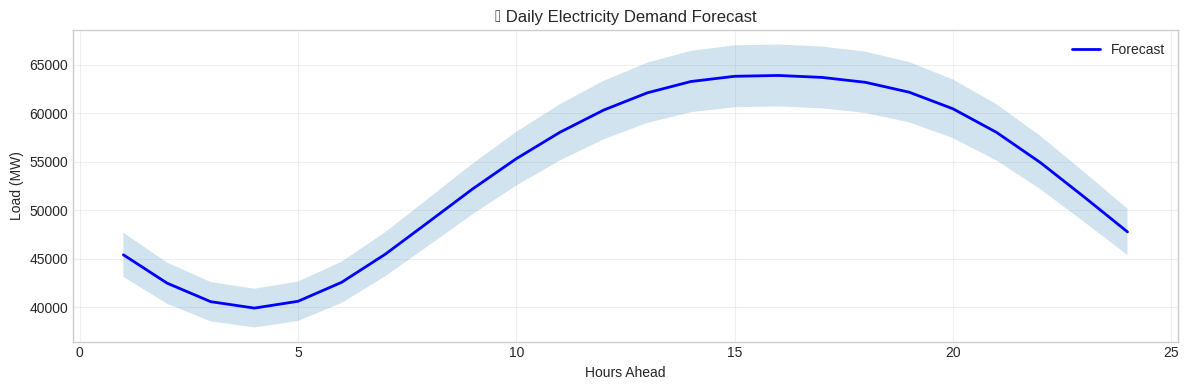

In [2]:
# ============================================================================
# INFERENCE: LOAD AND USE TRAINED MODELS
# ============================================================================

import numpy as np
import pickle
import json
from pathlib import Path
from tensorflow import keras

SAVE_DIR = Path('/content/drive/MyDrive/electricity_forecast_multihorizon')

def load_forecaster(horizon_name='daily'):
    """Load a trained forecaster."""

    # Load model
    model = keras.models.load_model(SAVE_DIR / 'models' / f'{horizon_name}_model.keras')

    # Load scalers
    with open(SAVE_DIR / 'scalers' / f'{horizon_name}_feature_scaler.pkl', 'rb') as f:
        feature_scaler = pickle.load(f)
    with open(SAVE_DIR / 'scalers' / f'{horizon_name}_target_scaler.pkl', 'rb') as f:
        target_scaler = pickle.load(f)

    # Load feature columns
    with open(SAVE_DIR / 'data' / 'feature_cols.json', 'r') as f:
        feature_cols = json.load(f)

    return model, feature_scaler, target_scaler, feature_cols


def forecast(input_data, horizon_name='daily'):
    """
    Generate forecast from input data.

    Args:
        input_data: DataFrame with same features used in training
                   Shape should be (lookback, n_features)
        horizon_name: 'daily', 'weekly', or 'monthly'

    Returns:
        predictions: Array of forecasted MW values
    """
    model, feat_scaler, tgt_scaler, feat_cols = load_forecaster(horizon_name)

    # Prepare input
    X = input_data[feat_cols].values
    X_scaled = feat_scaler.transform(X.reshape(-1, X.shape[-1])).reshape(1, *X.shape)

    # Predict
    pred_scaled = model.predict(X_scaled, verbose=0)
    pred = tgt_scaler.inverse_transform(pred_scaled.reshape(-1, 1)).flatten()

    return pred


# ============================================================================
# EXAMPLE USAGE
# ============================================================================

# Load your test data or new data
# Assuming 'df' is your DataFrame with the same features

# Get the last 72 hours for daily forecast
lookback_hours = {'daily': 72, 'weekly': 168, 'monthly': 336}

# Example: Generate daily forecast
horizon = 'daily'
input_window = df.tail(lookback_hours[horizon])  # Last 72 hours
forecast_values = forecast(input_window, horizon)

print(f"\n📈 {horizon.upper()} FORECAST ({len(forecast_values)} hours):")
print(f"   Hour 1:  {forecast_values[0]:,.0f} MW")
print(f"   Hour 12: {forecast_values[11]:,.0f} MW")
print(f"   Hour 24: {forecast_values[23]:,.0f} MW")

# Visualize forecast
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 4))
hours = range(1, len(forecast_values) + 1)
ax.plot(hours, forecast_values, 'b-', linewidth=2, label='Forecast')
ax.fill_between(hours, forecast_values * 0.95, forecast_values * 1.05, alpha=0.2)
ax.set_xlabel('Hours Ahead')
ax.set_ylabel('Load (MW)')
ax.set_title(f'⚡ {horizon.title()} Electricity Demand Forecast')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

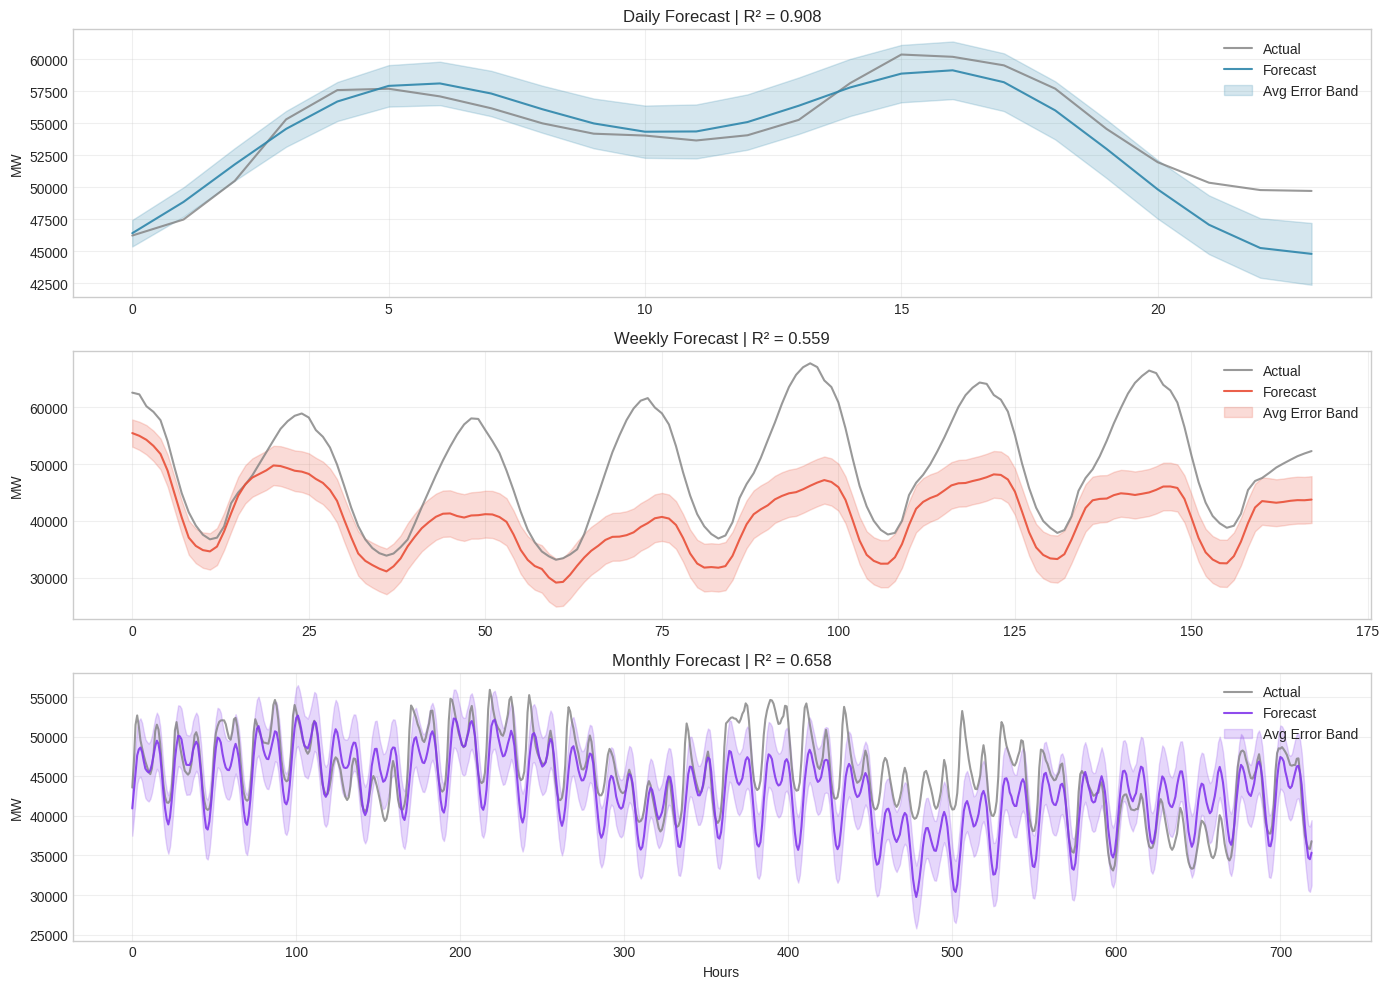

In [3]:
# Load and visualize saved predictions
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(3, 1, figsize=(14, 10))
colors = {'daily': '#2E86AB', 'weekly': '#E94F37', 'monthly': '#8338EC'}

for idx, horizon in enumerate(['daily', 'weekly', 'monthly']):
    ax = axes[idx]

    pred = np.load(SAVE_DIR / 'data' / f'{horizon}_predictions.npy')
    true = np.load(SAVE_DIR / 'data' / f'{horizon}_actuals.npy')

    # Plot multiple samples
    sample_idx = 100
    hours = range(pred.shape[1])

    ax.plot(hours, true[sample_idx], 'gray', alpha=0.8, label='Actual', linewidth=1.5)
    ax.plot(hours, pred[sample_idx], colors[horizon], alpha=0.9, label='Forecast', linewidth=1.5)

    # Error band
    errors = np.abs(true - pred)
    mean_error = errors.mean(axis=0)
    ax.fill_between(hours, pred[sample_idx] - mean_error, pred[sample_idx] + mean_error,
                    color=colors[horizon], alpha=0.2, label='Avg Error Band')

    ax.set_ylabel('MW')
    ax.set_title(f'{horizon.title()} Forecast | R² = {all_results[horizon]["metrics"]["r2"]:.3f}')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)

axes[-1].set_xlabel('Hours')
plt.tight_layout()
plt.savefig(SAVE_DIR / 'plots' / 'forecast_comparison_detailed.png', dpi=150)
plt.show()